# Character-level RNN for beer.stackoverflow.com

## How does an RNN work?

**1. Gather and clean training data:**

In [1]:
from xml.etree import cElementTree as ET
import sys
from HTMLParser import HTMLParser
import time

# credit: http://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

posts = open('Posts.xml', 'r').read()

posts[1:100]

def remove_tags(text):
    return ''.join(ET.fromstring(text).itertext())

root = ET.fromstring(posts)
documents = []
t0 = time.time()
for child in root.findall('row'):
    text = None
    child_text = child.get('Body').encode('utf-8').strip()
    text = strip_tags(child_text)
    # Remove line breaks so posts are grouped together
    text = text.replace("\n","")
    documents.append(text)
t1 = time.time()    

print 'Time to parse text: ' + str(t1 - t0)
print documents[0:2]
print 'Total number of documents: ' + str(len(documents))

Time to parse text: 0.156849861145
['I was offered a beer the other day that was reportedly made with citra hops. What are citra hops? Why should I care that my beer is made with them?', 'As far as we know, when did humans first brew beer, and where? Around when would you have been able to get your hands on something resembling a modern lager?']
Total number of documents: 1694


**2. Create dictionaries mapping characters to integers and back again.**

In [122]:
all_posts = ("\n\n").join(documents[0:10])

print all_posts[0:1000]

data = all_posts
chars = list(set(data))
data_size, vocab_size = len(data), len(chars)
print 'data has %d characters, %d unique.' % (data_size, vocab_size)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

I was offered a beer the other day that was reportedly made with citra hops. What are citra hops? Why should I care that my beer is made with them?

As far as we know, when did humans first brew beer, and where? Around when would you have been able to get your hands on something resembling a modern lager?

How is low/no alcohol beer made? I'm assuming that the beer is made normally and the alcohol is then removed, is it any more than just boiling it off? I've noticed that no/low alcohol beers' taste improved hugely a few years ago, is this due to a new technique?

Citra is a registered trademark since 2007. Citra Brand hops have fairly high alpha acids and total oil contents with a low percentage of cohumulone content and  imparts interesting citrus and tropical fruit characters to beer.For more information, you can read the Wikipedia article on the Citra brand.

In general, what's the best way to work out the temperature at which to serve a particular beer? Room temperature? Cold? Sup

**3. Train**

1. Initialize randomized weights for each neuron
2. Backpropagate a loss for those weights, using a target class of the next character
3. Update weights via Adagrad

In [123]:
execfile('two_rnn.py')
import time

max_iters = 10000
batch_sizes = [10,20,30,40,50]
losses_dict = {}
for bs in batch_sizes:
    start = time.time()
    print "Processing batch size " + str(bs)
    results = train(data, vocab_size, max_iters, bs)
    print len(results['losses'])
    losses_dict[bs] = results['losses']
    end = time.time()
    print "Training for " + str(max_iters) + " iterations lasted for " + str(end - start) + " seconds."
    print("\n")

h0 = results['h0']
h1 = results['h1']

Processing batch size 10
10000
Training for 10000 iterations lasted for 8.14329910278 seconds.


Processing batch size 20
10000
Training for 10000 iterations lasted for 13.2167348862 seconds.


Processing batch size 30
10000
Training for 10000 iterations lasted for 19.5705218315 seconds.


Processing batch size 40
10000
Training for 10000 iterations lasted for 26.8700270653 seconds.


Processing batch size 50
10000
Training for 10000 iterations lasted for 34.9209780693 seconds.




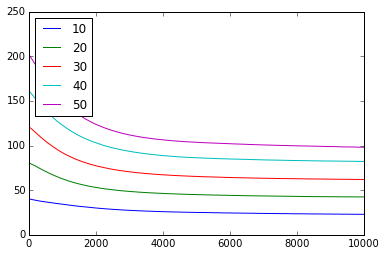

In [124]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(max_iters)

for bs in batch_sizes:
    plt.plot(x, losses_dict[bs])
    
legend_items = [str(bs) for bs in batch_sizes]

plt.legend(legend_items, loc='upper left')
plt.show()


In [125]:
execfile('two_rnn.py')
import time

max_iters = 100000
bs = 25

start = time.time()
results = train(data, vocab_size, max_iters, bs)
losses = results['losses']
end = time.time()
print "Training for " + str(max_iters) + " iterations lasted for " + str(end - start) + " seconds."
print("\n")

h0 = results['h0']
h1 = results['h1']

Training for 100000 iterations lasted for 170.403164864 seconds.




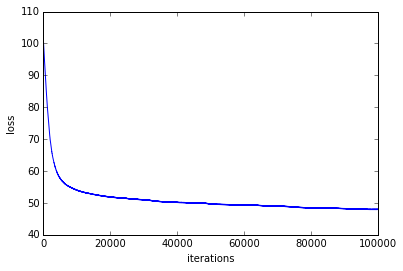

In [126]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iterations')
plt.show()

In [130]:
nsamples = 1000
bidx = char_to_ix['P']
samples = sample(h0, h1, bidx, nsamples)
#unicode('\x80abc', errors='ignore')
("").join([unicode(ix_to_char[samples[i]], errors = 'ignore') for i in range(nsamples)])

u"Aheheiraaeeaaaera'aeaeea?aey g d Cseeeeey veiut n (d?eiaeeaaailorat d f V  w f pao pos cek reeeaeaalhaey reiheut po dp paireaaypaay d d I w w w vireme paaad aiuy d w CeiV (haek lssm heea w viius m d,ay rit iut learely)eee, y w d C g Cails w b d d peeeeeaaay)eihaeeteeiuceaeiha w r, peiy d C w paereeeV he f g peeitat f f s dDae f w d f f t w ak glhaik d haata saam b d d, C d w d seeeeae'o)ay C no ud f?ipo?imucat)haa py b (vos veao w dsee, paalayut ham, us?iaimey d s ae'eiuceaat.eo d paik w?eat. we d d miaiuk w peey d d.?y. d vo w f f (d?eig sut aateeireeee.eaeeeaireeat?o b vak miuco wimaeaeeaeeieak?o f w. reiut rae dt d w C,eyset k'a vaeeeay. w caleeeeDt m, d?eiaad h w. s d d v!eaeeo vahoeeel pDd pay t s driud fia aeek C w ut w po r heiay w w d s d veeeileaeae st peiut g r C d\nd,eeeet w w pea s d reeeaa d ud houcaeea Ceiisak d aiy d (d C peo m hey w, w d ca po d (po heae peeiaits)o w C w. us, peaik d f w pezseey C velam piaeeeaco me w w peae w)eeaaheeaiut wreeayeaeeeeiheirik meucaeimt